In [42]:
import pandas as pd

url = "https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/spider_wolff_gorb_2013.csv"
df = pd.read_csv(url, skiprows=1)

# View the data
print(df.head())

print(df.info())

  leg  type  friction
0  L1  pull      0.90
1  L1  pull      0.91
2  L1  pull      0.86
3  L1  pull      0.85
4  L1  pull      0.80
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   leg       282 non-null    object 
 1   type      282 non-null    object 
 2   friction  282 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.7+ KB
None


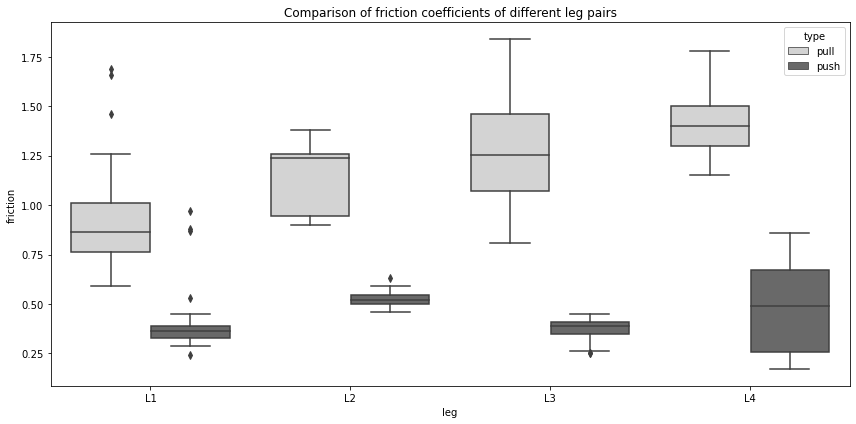

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='leg', y='friction', hue='type', 
           palette=['lightgray', 'dimgray'])

plt.title("Comparison of friction coefficients of different leg pairs")  
plt.tight_layout()
plt.show()

## Linear model with one variable

In [44]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Filter data for L1 leg only
spider_sub = df[df['leg'] == 'L1']

# Create dummy variable for type (0 = pull, 1 = push)
spider_sub_copy = spider_sub.copy()
spider_sub_copy['type_encoded'] = (spider_sub_copy['type'] == 'push').astype(int)

# Fit linear regression
X = spider_sub_copy[['type_encoded']]
y = spider_sub_copy['friction']

model = LinearRegression()
model.fit(X, y)

# Get results
intercept = model.intercept_
coef = model.coef_[0]
r2 = r2_score(y, model.predict(X))

print(f"Linear model results:")
print(f"(Intercept): {intercept:.6f}")
print(f"typepush: {coef:.6f}")
print(f"R-squared: {r2:.4f}")

Linear model results:
(Intercept): 0.921471
typepush: -0.514118
R-squared: 0.5776


In [45]:
import pandas as pd
import statsmodels.formula.api as smf

# Filter to only the L1 leg
df_sub = df[df['leg'] == 'L1']

# Fit the linear model: friction ~ type
model = smf.ols('friction ~ type', data=df_sub).fit()

# Show summary
print(model.summary())

# Coefficients
coefs = model.params
print(coefs)

# Show group means
grouped = df_sub.groupby('type')['friction']
mean_pull = grouped.get_group('pull').mean()
mean_diff = grouped.get_group('push').mean() - mean_pull


#The estimated coefficients are the mean of the pull observations (intercept), and the difference between the means of the two groups (typepush). 
print("Mean of pull:", mean_pull)
print("Mean difference (push - pull):", mean_diff)



                            OLS Regression Results                            
Dep. Variable:               friction   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     90.23
Date:                Mon, 04 Aug 2025   Prob (F-statistic):           5.70e-14
Time:                        23:14:55   Log-Likelihood:                 6.5195
No. Observations:                  68   AIC:                            -9.039
Df Residuals:                      66   BIC:                            -4.600
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9215      0.038     24.078   

## Design Matrix 

Design matrix is a numerical representation of the predictor variables.  The rows are observations and the columns are predictors or transformations of predictors.  We are modeling friction by "type": a categorical variable with values "pull" and "push".  The design matrix is what the regression algorithm uses to estimate coefficients.

The type[T.push] column:
    Is 0 when type == "pull"
    Is 1 when type == "push"
    
    Friction(i) =β0 +β1 ⋅I(typei ="push")+εi 
    
β0 is the mean friction for pull
β1 is the difference in mean friction between push and pull

In [46]:
from patsy import dmatrix

# Design matrix: intercept + one-hot encoding for 'type'
X = dmatrix('~ type', data=df_sub, return_type='dataframe')

# Column names
print(X.columns.tolist())
# ['Intercept', 'type[T.push]']

# First few rows
print(X.head())

# Last few rows
print(X.tail())


['Intercept', 'type[T.push]']
   Intercept  type[T.push]
0        1.0           0.0
1        1.0           0.0
2        1.0           0.0
3        1.0           0.0
4        1.0           0.0
    Intercept  type[T.push]
63        1.0           1.0
64        1.0           1.0
65        1.0           1.0
66        1.0           1.0
67        1.0           1.0


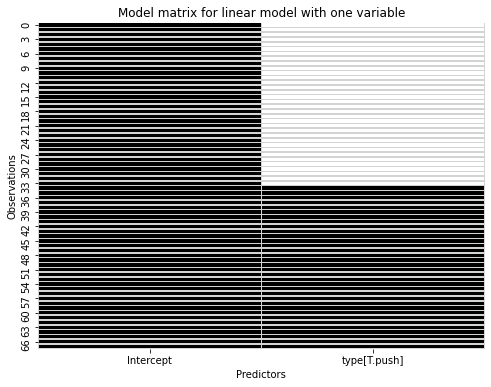

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure X is a DataFrame, e.g., from patsy.dmatrix(...)
# Plot the design matrix
plt.figure(figsize=(8, 6))
sns.heatmap(X, cmap="Greys", cbar=False, linewidths=0.5, linecolor='lightgray')
plt.title("Model matrix for linear model with one variable")
plt.xlabel("Predictors")
plt.ylabel("Observations")
plt.show()



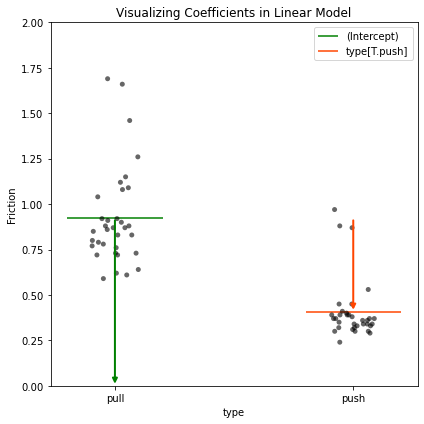

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Subset to L1 leg
df_sub = df[df['leg'] == 'L1']

# Fit model
import statsmodels.formula.api as smf
model = smf.ols('friction ~ type', data=df_sub).fit()
coefs = model.params

# Extract estimates
intercept = coefs['Intercept']
coef_push = coefs['type[T.push]']
push_mean = intercept + coef_push

# Create the plot
plt.figure(figsize=(6, 6))

# Jittered strip plot (scatter by group)
sns.stripplot(x='type', y='friction', data=df_sub, jitter=True, color='black', alpha=0.6)

# Horizontal lines for group means
plt.hlines(intercept, -0.2, 0.2, colors='green', linestyles='-', label='(Intercept)')
plt.hlines(push_mean, 0.8, 1.2, colors='orangered', linestyles='-', label='type[T.push]')

# Arrows
plt.annotate('', xy=(0, intercept), xytext=(0, 0),
             arrowprops=dict(arrowstyle='<|-', color='green', lw=2))
plt.annotate('', xy=(1, push_mean), xytext=(1, intercept),
             arrowprops=dict(arrowstyle='-|>', color='orangered', lw=2))

# Labels
plt.xticks([0, 1], ['pull', 'push'])
plt.ylabel('Friction')
plt.title('Visualizing Coefficients in Linear Model')
plt.legend(loc='upper right')

plt.ylim(0, max(df_sub['friction'].max(), 2))
plt.tight_layout()
plt.show()


## Linear Model with Two Variables

   Intercept  type[T.push]  leg[T.L2]  leg[T.L3]  leg[T.L4]
0          1             0          0          0          0
1          1             0          0          0          0
2          1             0          0          0          0
3          1             0          0          0          0
4          1             0          0          0          0


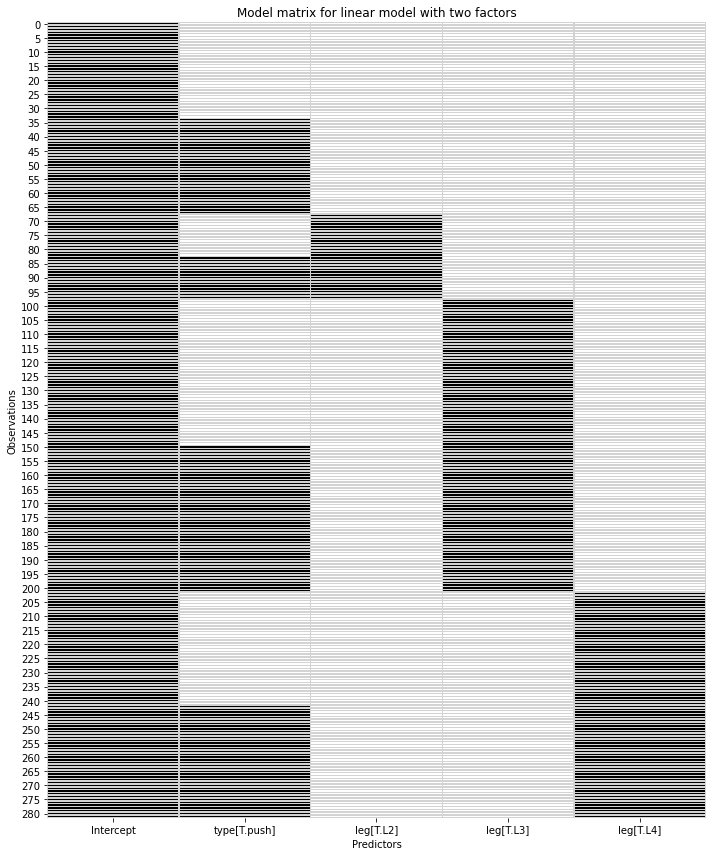

In [53]:
from patsy import dmatrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Build design matrix
X = dmatrix('~ type + leg', data=df, return_type='dataframe')

# Step 2: Round values to 0 and 1 to avoid floating point artifacts
X_binary = X.round(0).astype(int)

# Optional: inspect a few rows
print(X_binary.head())

# Step 3: Plot the cleaned matrix
# plt.figure(figsize=(10, 6))
# sns.heatmap(X_binary, cmap="Greys", cbar=False, vmin=0, vmax=1,
#             linewidths=0.2, linecolor='lightgray')

# plt.title("Model matrix for linear model with two factors")
# plt.xlabel("Predictors")
# plt.ylabel("Observations")
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(10, 12))  # Taller figure makes rows wider
sns.heatmap(
    X_binary,
    cmap="Greys",
    cbar=False,
    vmin=0, vmax=1,
    linewidths=0.5,
    linecolor='lightgray',
    square=False  # Key: allows rectangular cells instead of forced squares
)
plt.title("Model matrix for linear model with two factors")
plt.xlabel("Predictors")
plt.ylabel("Observations")
plt.tight_layout()
plt.show()




In [55]:
import pandas as pd
import statsmodels.formula.api as smf

# Assuming `spider` is already a pandas DataFrame
# Example:
# spider = pd.read_csv("spider.csv")

# Fit the model
fitTL = smf.ols('friction ~ type + leg', data=df).fit()

# Summary (similar to R's summary(fitTL))
print(fitTL.summary())

# Coefficients (similar to coefs <- coef(fitTL))
coefs = fitTL.params
print(coefs)


                            OLS Regression Results                            
Dep. Variable:               friction   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     263.0
Date:                Sat, 09 Aug 2025   Prob (F-statistic):           5.26e-93
Time:                        10:36:49   Log-Likelihood:                 44.590
No. Observations:                 282   AIC:                            -79.18
Df Residuals:                     277   BIC:                            -60.97
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0539      0.028     37.426   